<a href="https://colab.research.google.com/github/SLCFLAB/hd2025_time_series/blob/main/day2/Day2_time_series_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 단순 예측

노트북은 `statsmodels`의 Sunspot 데이터를 이용해 세 가지 단순 예측 기법을 비교하겠습니다.

예측 기법
- Naive: $\hat y_t = y_{t-1}$
- Seasonal Naive: $\hat y_t = y_{t-s}$ (여기서는 s=10)
- Mean: 학습 구간 평균값을 사용

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# 데이터 로드 및 전처리
sunspot = sm.datasets.sunspots.load_pandas().data
sunspot = sunspot.rename(columns={"YEAR": "year", "SUNACTIVITY": "sunactivity"})
sunspot.year = sunspot.year.astype(int)
sunspot = sunspot.set_index("year")

In [3]:
sunspot

,sunactivity
year,
1700,5.0
1701,11.0
1702,16.0
1703,23.0
1704,36.0
...,...
2004,40.4
2005,29.8
2006,15.2


In [4]:
forecast_start = 1997

# Naive forecast
sunspot['Naive'] = sunspot.loc[forecast_start - 1, 'sunactivity']

# Naive seasonal forecast
seasonality = 10
sunspot['Naive_Seasonal'] = sunspot.loc[:,'sunactivity'].shift(seasonality)

# Mean forecast
sunspot['Mean'] = sunspot.loc[:forecast_start,'sunactivity'].mean()

In [5]:
# 예측 구간 외에는 마스킹 처리
naive_mask = (sunspot.index >= forecast_start)
naive_seasonal_mask = (sunspot.index >= forecast_start)
mean_mask = (sunspot.index >= forecast_start)

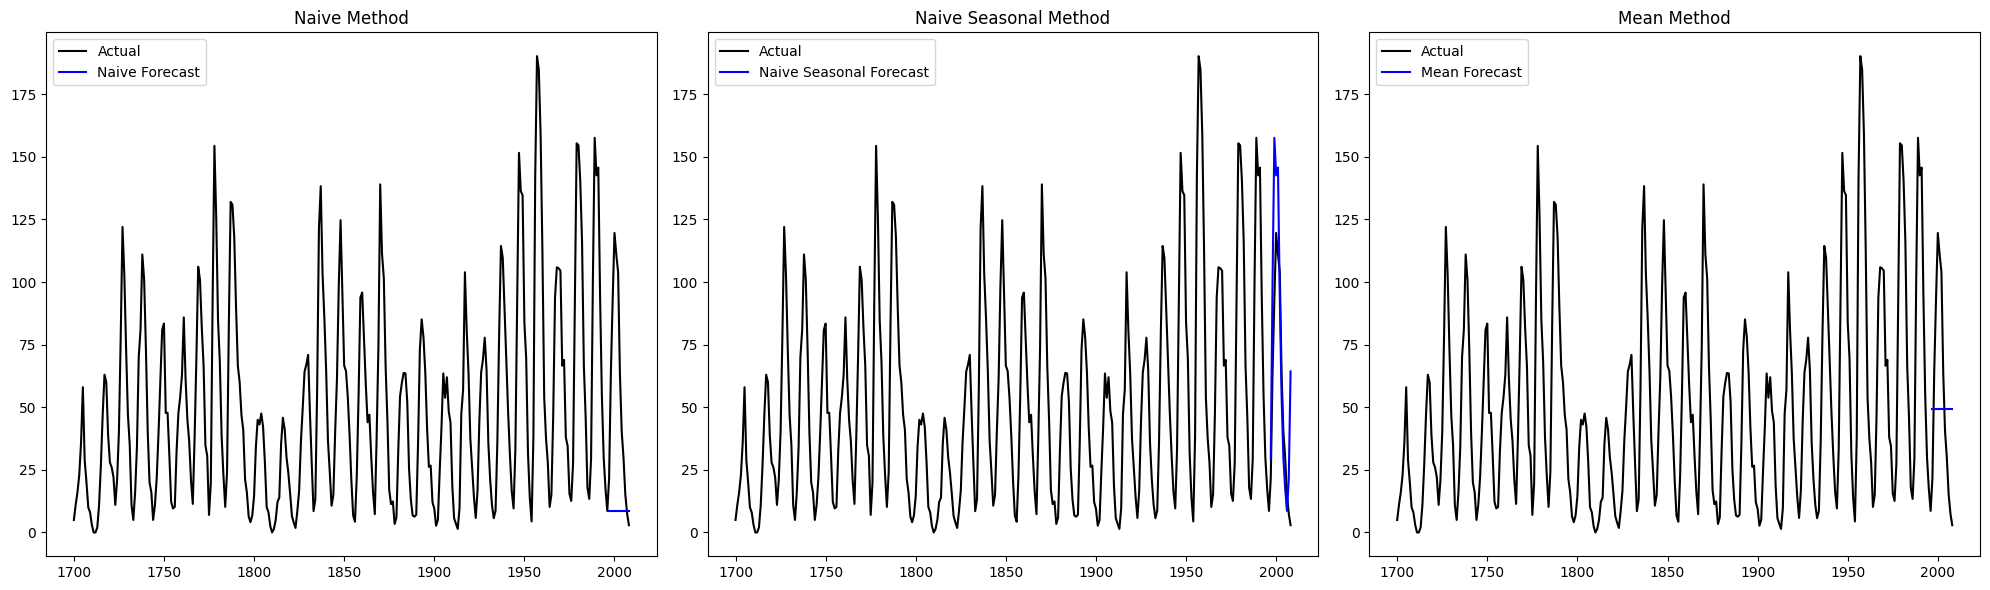

In [6]:
# 시각화
plt.figure(figsize=(20,6))

plt.subplot(131)
plt.plot(sunspot['sunactivity'], label='Actual', color='black')
plt.plot(sunspot.index[naive_mask], sunspot['Naive'][naive_mask], label='Naive Forecast', color='blue')
plt.title('Naive Method')
plt.legend()

plt.subplot(132)
plt.plot(sunspot['sunactivity'], label='Actual', color='black')
plt.plot(sunspot.index[naive_seasonal_mask], sunspot['Naive_Seasonal'][naive_seasonal_mask], label='Naive Seasonal Forecast', color='blue')
plt.title('Naive Seasonal Method')
plt.legend()

plt.subplot(133)
plt.plot(sunspot['sunactivity'], label='Actual', color='black')
plt.plot(sunspot.index[mean_mask], sunspot['Mean'][mean_mask], label='Mean Forecast', color='blue')
plt.title('Mean Method')
plt.legend()

plt.tight_layout()
plt.show()

# 선형 회귀 예시

동일한 Sunspot 데이터를 활용해서 기본적인 선형 회귀에 대한 예시를 확인해보겠습니다.

In [7]:
sunspot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 1700 to 2008
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sunactivity     309 non-null    float64
 1   Naive           309 non-null    float64
 2   Naive_Seasonal  299 non-null    float64
 3   Mean            309 non-null    float64
dtypes: float64(4)
memory usage: 20.2 KB


In [8]:
# 선형 회귀 모델 피팅
X = sm.add_constant(sunspot.index)
y = sunspot['sunactivity']

model = sm.OLS(y, X, missing='drop').fit()

sunspot['Linear_Forecast'] = model.predict(X)

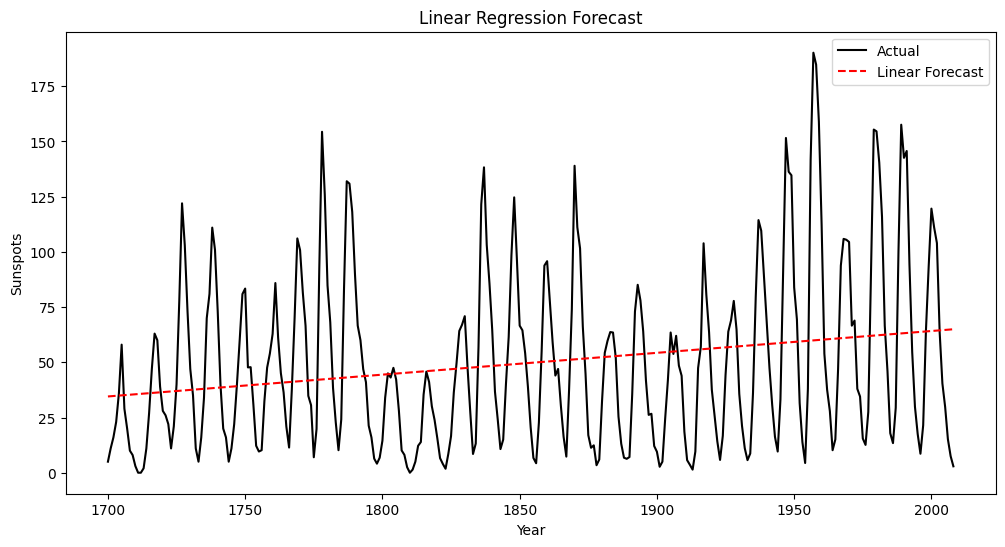

In [9]:
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(sunspot['sunactivity'], label='Actual', color='black')
plt.plot(sunspot['Linear_Forecast'], label='Linear Forecast', color='red', linestyle='--')
plt.title('Linear Regression Forecast')
plt.xlabel('Year')
plt.ylabel('Sunspots')
plt.legend()
plt.show()

# 선형 회귀의 금융 예시 - CAPM (Capital Asset Pricing Model. 자본자산가격결정모형)

하나의 주식과 시장 간의 **CAPM 회귀(CAPM-style regression)** 를 일별 데이터로 추정하고, 통계적 유의성과 시각적 진단을 수행한다. CAPM은 기본적으로 risk-free asset에 대한 초과 수익률을 모델링 하지만 본 실습에서는 risk-free asset의 기대 수익률이 0이라고 가정하고 실습을 진행하겠습니다.

---

## **Pipeline**

### 1. **데이터 다운로드**

* 주식과 시장 지수(Market Index)의 **Adj Close** 데이터를 다운로드(본 실습에서는 준비된 데이터 활용)한다.

### 2. **수익률 계산**

* `pct_change()` 함수를 사용하여 일별 단순 수익률(Simple Daily Returns)을 계산한다.

### 3. **OLS 회귀 실행**

* 다음의 **CAPM 회귀모형**을 추정한다:
  $$
  r_{i,t} = \alpha + \beta, r_{m,t} + \varepsilon_t
  $$

  * ( $r_{i,t}$ ): 주식의 일별 수익률
  * ( $r_{m,t}$ ): 시장 수익률
  * ( $\alpha$ ): 초과수익률(Alpha)
  * ( $\beta$ ): 시장 민감도(Market Sensitivity)

### 4. **β의 통계적 추론 (t-test)**

* β에 대한 t-통계량은 다음과 같이 계산한다:
  $$
  t(\beta)=\frac{\hat\beta}{\mathrm{SE}(\hat\beta)},
  \quad
  \mathrm{SE}(\hat\beta)=\frac{s_\varepsilon}{\sqrt{\sum_t (r_{m,t}-\bar r_m)^2}}
  $$

  * ( $s_\varepsilon$ ): 잔차의 표준오차 (Residual Standard Error)

### 5. **적합도 평가 (Model Fit)**

* 결정계수 ( R^2 ) 를 이용해 모델의 설명력을 평가한다:
  $$
  R^2 = 1 - \frac{SSE}{SST}
  $$

### 6. **시각화 (Visualization)**

* **Scatter Plot**: 시장수익률 vs 주식수익률 산점도 및 추정된 CAPM 회귀선
* **Cumulative Return Plot**: 주식과 시장의 누적수익률 비교
* **Residual Plot**: 잔차의 시간적 추이를 시각화

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
from scipy.stats import t as t_dist

In [11]:
# 1. 데이터 불러오기 (최근 2년)
ticker_stock = 'AAPL'    # Apple
ticker_market = '^GSPC'  # S&P 500

from urllib.parse import urljoin
data_repo_url = "https://raw.githubusercontent.com/SLCFLAB/hd2025_time_series/refs/heads/main/datasets/"
stock_data_path = urljoin(data_repo_url, "aapl.csv")
market_data_path = urljoin(data_repo_url, "snp500.csv")

stock_data = pd.read_csv(stock_data_path, index_col=0, parse_dates=True)
market_data = pd.read_csv(market_data_path, index_col=0, parse_dates=True)

stock_df = stock_data.loc[stock_data.index.year >= 2023]['Adj Close']
market_df = market_data.loc[market_data.index.year >= 2023]['Adj Close']

In [12]:
# 2. 수익률 계산
returns_stock = stock_df.pct_change().dropna()
returns_market = market_df.pct_change().dropna()

returns_stock.name = ticker_stock
returns_market.name = ticker_market

# 데이터 정렬
df = pd.concat([returns_stock, returns_market], axis=1).rename({ticker_stock: "stock", ticker_market: "market"}, axis=1)

In [13]:
# 3. OLS 회귀분석
x = df['market'].values
y = df['stock'].values

# 베타 추정
beta_1 = np.cov(x, y)[0, 1] / np.var(x)
alpha = np.mean(y) - beta_1 * np.mean(x)

In [14]:
# 4. 통계적 유의성 검정
y_pred = alpha + beta_1 * x
residuals = y - y_pred
n = len(x)
se_residuals = np.sqrt(np.sum(residuals**2) / (n - 2))
se_beta = se_residuals / np.sqrt(np.sum((x - np.mean(x))**2))

t_stat = beta_1 / se_beta
p_value = 2 * (1 - t_dist.cdf(abs(t_stat), df=n-2))

print(f"CAPM Result: {ticker_stock} vs {ticker_market}")
print(f"{'='*50}")
print(f"Alpha (Intercept): {alpha:.6f}")
print(f"Beta (Market Sensitivity): {beta_1:.4f}")
print(f"t-stat: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# R² 계산
SST = np.sum((y - np.mean(y))**2)
SSE = np.sum(residuals**2)
R_squared = 1 - SSE/SST
print(f"R²: {R_squared:.4f}")

CAPM Result: AAPL vs ^GSPC
Alpha (Intercept): 0.000173
Beta (Market Sensitivity): 1.1954
t-stat: 25.4268
p-value: 0.0000
R²: 0.4834


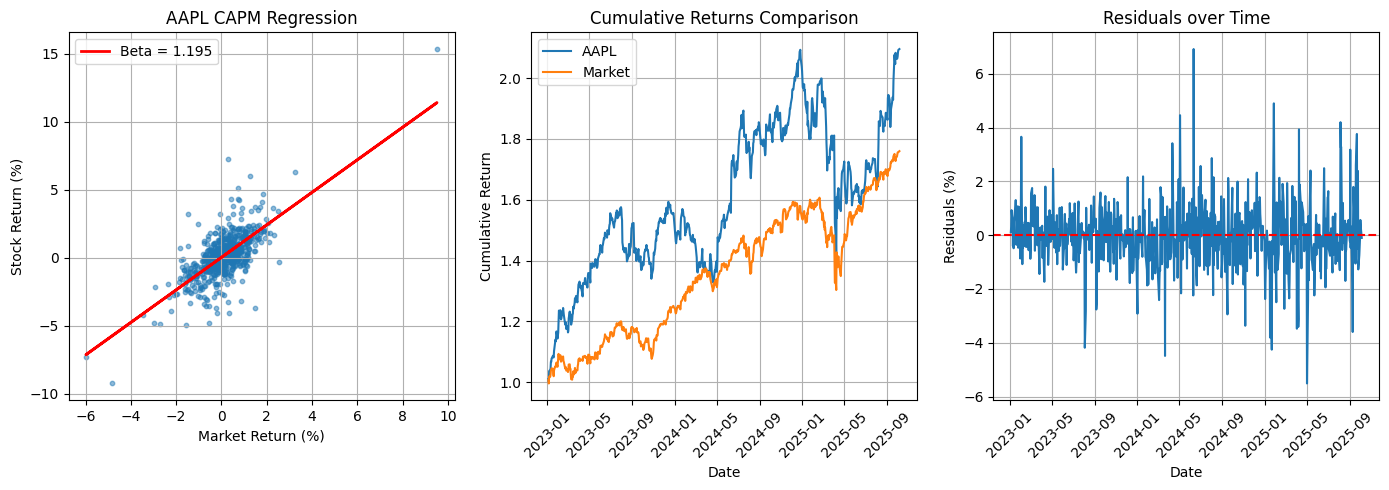

In [15]:
# 5. 시각화
plt.figure(figsize=(14, 5))

# 5-1. CAPM 회귀선
plt.subplot(1, 3, 1)
plt.scatter(x*100, y*100, alpha=0.5, s=10)
plt.plot(x*100, y_pred*100, 'r-', linewidth=2,
         label=f'Beta = {beta_1:.3f}')
plt.xlabel('Market Return (%)')
plt.ylabel('Stock Return (%)')
plt.title(f'{ticker_stock} CAPM Regression')
plt.legend()
plt.grid(True)

# 5-2. 시계열 플롯
plt.subplot(1, 3, 2)
plt.plot(df.index, (1 + df['stock']).cumprod(), label=ticker_stock)
plt.plot(df.index, (1 + df['market']).cumprod(), label='Market')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.grid(True)

# 5-3. 잔차의 시계열
plt.subplot(1, 3, 3)
plt.plot(df.index, residuals*100)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Residuals (%)')
plt.title('Residuals over Time')
plt.grid(True)

plt.tight_layout()
plt.show()

## 결과 해석 방법 (How to Read the Results and Plots)

---


### **회귀 결과 (예시: AAPL vs ^GSPC)**

* **Alpha (Intercept)**: 0.000173 (일간 약 0.0173%)
* **Beta (Market Sensitivity)**: ( $\hat{\beta} = 1.1954$ )
* **t-statistic for ( $\beta$ )**: ( $t = 25.4268$ )
* **p-value for ( $\beta$ )**: ( $p \approx 0.0000$ )
* **$R^2$**: 0.4834

---

### **해석 (Interpretation)**

* **Beta ≈ 1.20.**
  이 주식은 **시장보다 변동성이 더 큰(highly sensitive)** 종목이다.
  시장이 1% 변할 때, 평균적으로 이 주식은 약 **1.2% 정도 변동**하는 경향을 보인다.

* **통계적 유의성 (Statistical significance).**
  ( t = 25.4268 ), ( p $\approx$ 0.0000 )으로,
  **β는 매우 유의미한(statistically significant)** 결과를 보인다.

* **Alpha.**
  일간 ( $\alpha \approx 0.0173$% )로,
  이는 **작은 양의 절편(negative intercept)을** 의미한다.
  Alpha의 유의성 검정은 여기서 수행하지 않았지만,
  추가로 **표준오차(Standard Error)** 및 **t-검정**을 계산해 확장할 수 있다.

* **적합도 (Fit quality).**
  ( $R^2 = 0.4834$ )는
  일별 수익률 변동의 약 **48%가 시장수익률로 설명**됨을 의미하며,
  나머지는 개별적 요인(idiosyncratic risk)과 기타 리스크 요인에 의해 설명된다.

---

### **그래프 해석 (How to Read the Figures)**

* **Scatter Plot (시장수익률 vs 주식수익률)**
  점들이 기울기 ( $\hat{\beta} \approx 1.20$ )의 **상승하는 직선 주변에** 분포한다면,
  CAPM 관계가 잘 설명되고 있음을 의미한다.
  만약 곡선 형태나 **선형성 붕괴(비선형성)**, **부채꼴 형태(이분산성)가** 보이면
  모형의 단순 선형 가정이 위배될 수 있다. 현재는 잘 설명되고 있다.

* **Cumulative Return Plot (누적수익률 비교)**
  두 자산(주식 vs 시장)의 1 단위 투자 누적수익률을 비교한다.
  두 곡선이 벌어지는 구간은 **시장 대비 초과수익(Outperformance)**
  혹은 **저조한 수익(Underperformance)** 시기를 보여준다.

* **Residual Plot (잔차 시계열)**
  잔차가 0을 중심으로 무작위로 분포하면 좋은 모형이다.
  반면 **패턴, 군집(clustering), 분산 변화(heteroskedasticity)가** 나타난다면
  $\beta$의 시간가변성(time-varying beta), 변동성 군집(volatility clustering),
  혹은 누락된 위험요인(omitted risk factors)을 시사한다.

---

### **모형 가정 및 빠른 점검 (Assumptions and Quick Checks)**

* **선형성 및 등분산성 (Linearity & Homoskedasticity)**
  잔차 플롯에서 깔때기 형태나 체계적 패턴이 보인다면
  **강건표준오차(robust SE)** 사용 또는 **rolling/conditional beta** 모형을 고려할 수 있다.

* **동기화된 일별 데이터 (Synchronous Daily Data)**
  기업행동(corporate actions)이나 거래정지(trading halt)는 일별 수익률에 영향을 줄 수 있다.
  **Adj Close**를 사용했기 때문에 배당 및 분할 효과가 반영된 적절한 수익률이다.

* **Beta의 정상성 (Stationarity of Beta)**
  β가 시간이 지남에 따라 안정적인지 평가하기 위해
  **rolling regression**을 통해 β의 시계열적 변화를 관찰할 수 있다.

# 부트스트랩 예시

주가 모형에서 많이 사용되는 부트스트랩에 대해 다루겠습니다.

In [16]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-10-06 to 2025-10-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2515 non-null   float64
 1   Close      2515 non-null   float64
 2   High       2515 non-null   float64
 3   Low        2515 non-null   float64
 4   Open       2515 non-null   float64
 5   Volume     2515 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.5 KB


In [17]:
start_date = "2018-01-01"
end_date = "2023-12-31"

trimmed_stock_data = stock_data.loc[start_date:end_date]

<Axes: xlabel='Date'>

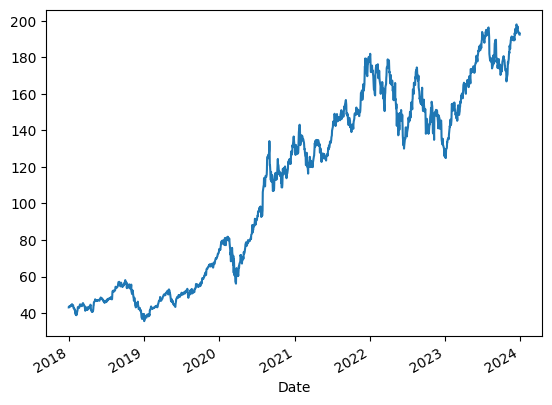

In [18]:
# trim된 데이터 확인 (종가)
trimmed_stock_data.Close.plot()

In [19]:
close = trimmed_stock_data['Close']
naive_forecast = close.shift(1)
residuals = close.diff(1)

In [20]:
# 부트스트랩
np.random.seed(0)
n_days = 100
n_simulations = 100
last_value = close.iloc[-1]

simulations = pd.DataFrame(index=range(n_days), columns=range(n_simulations))

for sim in range(n_simulations):
    simulated_values = [last_value]
    for day in range(1, n_days):
        simulated_values.append(simulated_values[day-1] + np.random.choice(residuals.dropna()))
    simulations[sim] = simulated_values

percentiles = [80, 95]
lower_bounds = simulations.quantile(q=(1-percentiles[0]/100)/2, axis=1)
upper_bounds = simulations.quantile(q=1-(1-percentiles[0]/100)/2, axis=1)
lower_bounds_95 = simulations.quantile(q=(1-percentiles[1]/100)/2, axis=1)
upper_bounds_95 = simulations.quantile(q=1-(1-percentiles[1]/100)/2, axis=1)

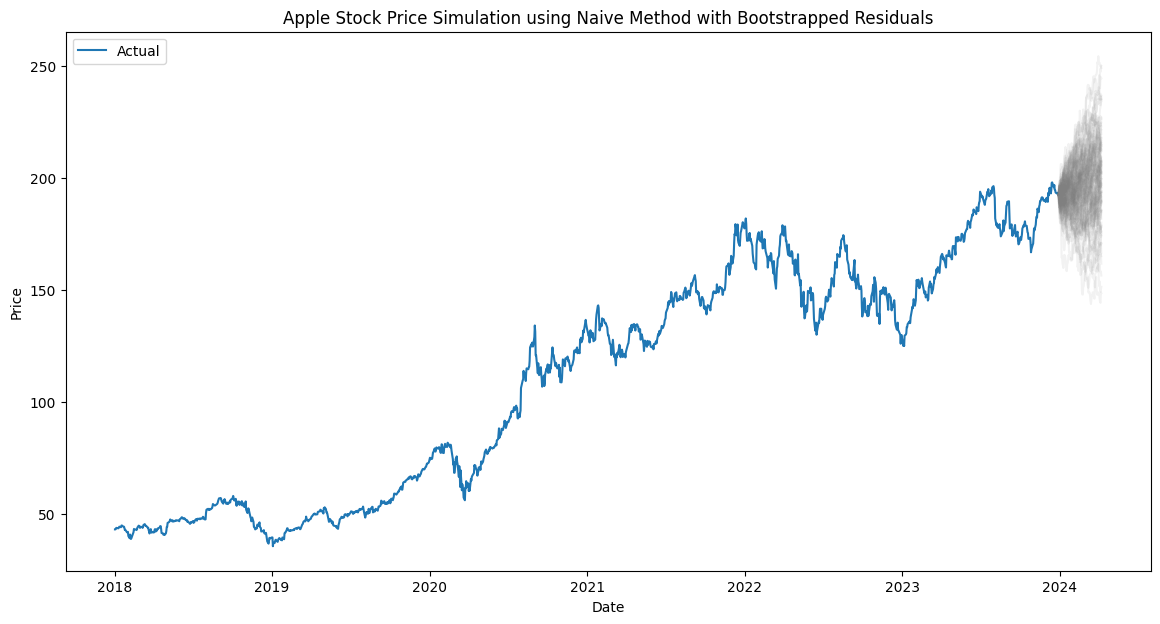

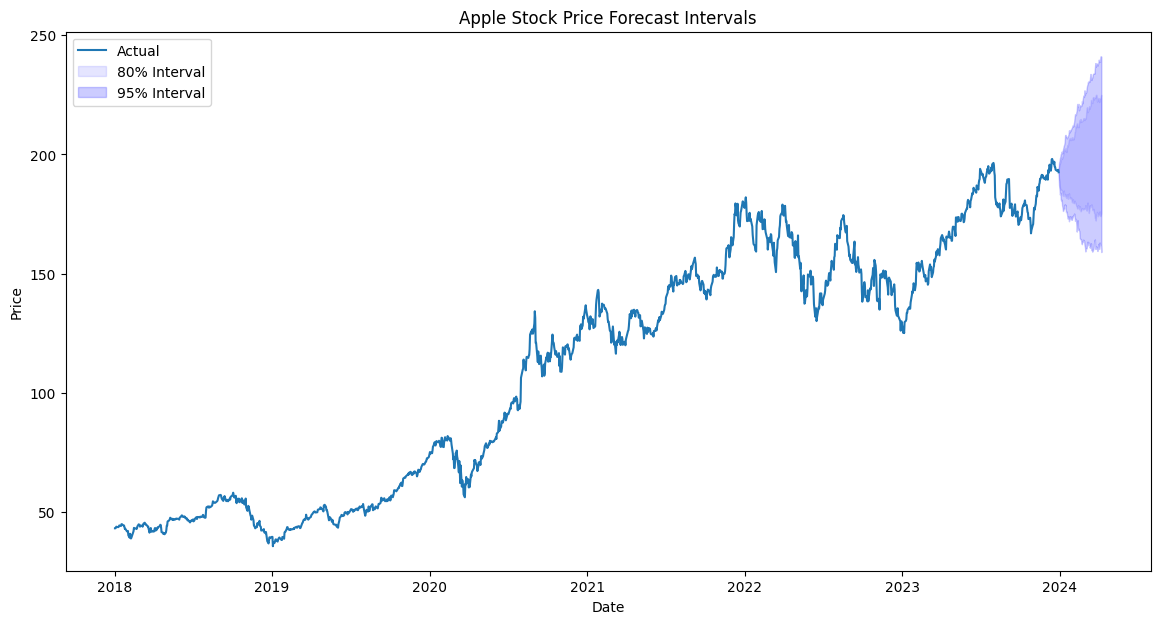

In [21]:
# 시각화
plt.figure(figsize=(14, 7))
plt.plot(close.index, close, label='Actual')
for sim in simulations.columns:
    plt.plot(close.index[-1] + pd.to_timedelta(range(n_days), unit='D'), simulations[sim], alpha=0.1, color='grey')
plt.title('Apple Stock Price Simulation using Naive Method with Bootstrapped Residuals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(close.index, close, label='Actual')
plt.fill_between(close.index[-1] + pd.to_timedelta(range(n_days), unit='D'), lower_bounds, upper_bounds, color='blue', alpha=0.1, label=f'{percentiles[0]}% Interval')
plt.fill_between(close.index[-1] + pd.to_timedelta(range(n_days), unit='D'), lower_bounds_95, upper_bounds_95, color='blue', alpha=0.2, label=f'{percentiles[1]}% Interval')
plt.title('Apple Stock Price Forecast Intervals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# 추세 모델링 (Trend Model)

이 실습에서는 소매 판매 데이터를 사용하여 시계열의 **추세(Trend)를** 모델링하는 세 가지 방법을 비교합니다. 각 모델의 특성과 적합성을 이해하고, 데이터에 가장 적합한 추세 모델을 선택하는 방법을 학습합니다.

## 추세(Trend)란?

**추세**는 시계열 데이터의 장기적인 방향성을 의미합니다:
- **상승 추세**: 시간이 지남에 따라 값이 증가
- **하락 추세**: 시간이 지남에 따라 값이 감소
- **수평 추세**: 장기적으로 변화 없음

소매 판매 데이터는 일반적으로 경제 성장, 인구 증가, 인플레이션 등으로 인해 **상승 추세**를 보입니다.

---

### 1. 선형 추세 모델 (Linear Trend)

**모델 형태:**
```
y = β₀ + β₁·Time + ε
```

**특징:**
- 가장 단순한 추세 모델
- 일정한 속도로 증가/감소
- 매 기간 **절대적 증가량**이 일정

**해석:**
- **β₀**: 시작 시점(Time=0)의 판매량
- **β₁**: 시간 단위당 판매량 증가량 (예: 월별 증가량)

**장점:**
-  이해하기 쉬움
-  해석이 직관적
-  계산이 빠름

**단점:**
-  성장률이 일정하지 않은 경우 부적합
-  복리 성장을 포착 못함
-  장기 예측 시 과소/과대 추정 가능

**적합한 경우:**
- 짧은 기간 데이터
- 성장이 안정적인 산업
- 선형 패턴이 명확한 경우

---

### 2. 지수 추세 모델 (Exponential Trend)

**모델 형태:**
```
y = exp(β₀ + β₁·Time + ε)
```

**추정 방법:**
로그 변환 후 선형 회귀:
```
log(y) = β₀ + β₁·Time + ε
```

**특징:**
- 매 기간 **상대적 증가율(성장률)**이 일정
- 복리 효과 반영
- 기하급수적 성장 포착

**해석:**
- **β₀**: log(초기값)
- **β₁**: 연속 복리 성장률
- **월별 성장률**: (exp(β₁) - 1) × 100%
- **연간 성장률**: (exp(12·β₁) - 1) × 100%

**장점:**
- 경제 성장, 인구 증가 등 복리 효과 포착
- 퍼센트 증가가 일정한 경우 적합
- 항상 양수 예측값 보장

**단점:**
- 로그 변환으로 해석 복잡
- y = 0 또는 음수 불가
- 무한 성장 가정 (현실적이지 않을 수 있음)

**적합한 경우:**
- 경제 지표 (GDP, 주가, 판매액)
- 장기 성장 데이터
- 복리 효과가 중요한 경우

---

### 3. 2차 다항 추세 모델 (Quadratic Trend)

**모델 형태:**
```
y = β₀ + β₁·Time + β₂·Time² + ε
```

**특징:**
- 추세의 **가속** 또는 **감속** 포착
- U자형 또는 역U자형 패턴
- 변곡점 존재 가능

**해석:**
- **β₀**: 시작 시점의 값
- **β₁**: 초기 변화율 (1차 효과)
- **β₂**: 가속도 (2차 효과)
  - β₂ > 0: 가속 성장 (위로 볼록)
  - β₂ < 0: 감속 성장 (아래로 볼록)

**장점:**
- 비선형 추세 포착
- 성장률 변화 반영
- 유연한 모델링

**단점:**
- 과적합 위험
- 외삽 (Extrapolation)) 시 불안정 (급격한 증가/감소)
- 물리적 의미 불분명할 수 있음

**적합한 경우:**
- S자형 성장 초기/말기 단계
- 제품 수명 주기
- 가속/감속이 명확한 데이터

---

## 모델 선택 기준

### 1. 시각적 검토

**원본 데이터 플롯:**
- 직선처럼 보이는가? → 선형 모델
- 곡선이면서 계속 가팔라지는가? → 지수 모델
- 변곡점이나 U자형인가? → 2차 모델

### 2. 통계적 지표

R², Adjusted R², RMSE, MAE, AIC, BIC, ...

**주의사항:**
- 통계적 지표 하나만으로 판단하지 말 것
- 잔차 패턴 확인 필수
- 과적합 경계 (특히 고차 모델)

### 3. 잔차 분석

**좋은 모델의 잔차:**
- 평균 ≈ 0
- 일정한 분산 (등분산성)
- 정규분포
- 무작위 패턴 (자기상관 없음)

**나쁜 신호:**
- 체계적 패턴 (곡선, 추세)
- 분산이 시간에 따라 변함
- 이상치 다수
- 비정규성

### 4. 경제적/이론적 타당성

**질문:**
- 모델이 현실을 반영하는가?
- 장기 예측이 합리적인가?
- 도메인 지식과 일치하는가?

**예시:**
- 소매 판매는 무한히 기하급수적으로 증가할 수 없음
- 포화 시장에서는 S자형 곡선이 더 합리적
- 단기에는 선형, 장기에는 로그 선형 고려

---

## 로그 변환 이해하기

### 왜 로그를 사용하는가?

1. **곱셈 관계 → 덧셈 관계**
   ```
   y = a × b^t  (지수 관계)
   log(y) = log(a) + t·log(b)  (선형 관계)
   ```

2. **퍼센트 증가율 일정**
   - 원본: 100 → 110 → 121 (10% 증가)
   - 로그: 일정한 기울기

3. **이분산성 완화**
   - 판매량이 클수록 변동도 큼
   - 로그 변환으로 분산 안정화

4. **양수 보장**
   - exp(·) 함수는 항상 양수
   - 판매량, 가격 등에 적합

### 로그 스케일 해석

**계수 해석:**
```
log(y) = β₀ + β₁·Time

→ β₁ = 0.01이면 월별 1% 증가
→ β₁ = 0.05이면 월별 5% 증가
```

**역변환:**
```python
log_prediction = model.predict(X)
prediction = np.exp(log_prediction)
```

**주의:** 로그 잔차의 R²와 원본 스케일의 R²는 다름!

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.rcParams['axes.unicode_minus'] = False

In [23]:
# =============================================================================
# 1. 데이터 로드 및 전처리
# =============================================================================
from urllib.parse import urljoin
data_repo_url = "https://raw.githubusercontent.com/SLCFLAB/hd2025_time_series/refs/heads/main/datasets/"
retail_data_path = urljoin(data_repo_url, "us_monthly_retail_sales.csv")
retail = pd.read_csv(retail_data_path)

In [24]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    404 non-null    object
 1   RSAFS   404 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ KB


In [25]:
retail

,DATE,RSAFS
0,1992-01-01,159177
1,1992-02-01,159189
2,1992-03-01,158647
3,1992-04-01,159921
4,1992-05-01,160471
...,...,...
399,2025-04-01,721789
400,2025-05-01,716101
401,2025-06-01,723033
402,2025-07-01,727414


In [26]:
# 날짜 형식 변환
retail['DATE'] = pd.to_datetime(retail['DATE'])

# 시간 변수 생성 (월 단위, 시작점 기준)
start_date = retail['DATE'].min()
retail['Time'] = np.arange(len(retail))

print("="*80)
print("데이터 기본 정보")
print("="*80)
print(f"데이터 기간: {retail['DATE'].min()} ~ {retail['DATE'].max()}")
print(f"총 관측치 수: {len(retail)}")
print(f"판매량 범위: {retail['RSAFS'].min():.2f} ~ {retail['RSAFS'].max():.2f}")
print("\n데이터 미리보기:")
print(retail.head(10))

데이터 기본 정보
데이터 기간: 1992-01-01 00:00:00 ~ 2025-08-01 00:00:00
총 관측치 수: 404
판매량 범위: 158647.00 ~ 732010.00

데이터 미리보기:
        DATE   RSAFS  Time
0 1992-01-01  159177     0
1 1992-02-01  159189     1
2 1992-03-01  158647     2
3 1992-04-01  159921     3
4 1992-05-01  160471     4
5 1992-06-01  161205     5
6 1992-07-01  162855     6
7 1992-08-01  162412     7
8 1992-09-01  164361     8
9 1992-10-01  166063     9


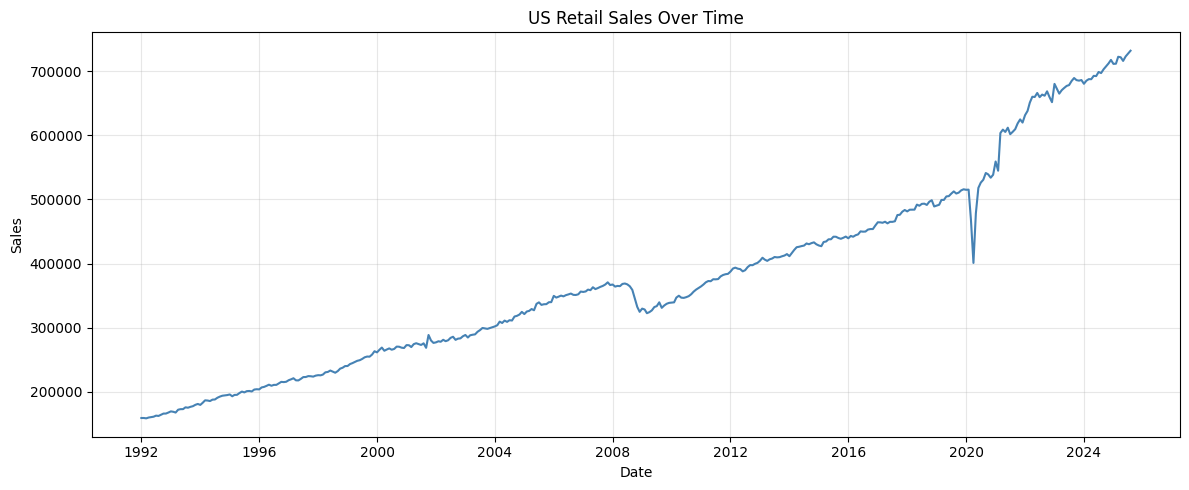

In [27]:
# =============================================================================
# 2. 원본 데이터 시각화
# =============================================================================

plt.figure(figsize=(12, 5))
plt.plot(retail['DATE'], retail['RSAFS'], linewidth=1.5, color='steelblue')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('US Retail Sales Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# =============================================================================
# 3. 모델 1: 선형 추세 모델 (Linear Trend)
# =============================================================================

# 선형 모델: y = β₀ + β₁·Time + ε
y_original = retail['RSAFS']
X_linear = add_constant(retail['Time'])

model_linear = OLS(y_original, X_linear).fit()

print("\n" + "="*80)
print("모델 1: 선형 추세 모델 (Linear Trend)")
print("="*80)
print(model_linear.summary())

# 예측값 생성
retail['Linear_Fitted'] = model_linear.predict(X_linear)
retail['Linear_Residual'] = y_original - retail['Linear_Fitted']

# 평가 지표
mse_linear = mean_squared_error(y_original, retail['Linear_Fitted'])
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y_original, retail['Linear_Fitted'])

print(f"\n선형 모델 평가:")
print(f"  R-squared: {model_linear.rsquared:.6f}")
print(f"  RMSE: {rmse_linear:.2f}")
print(f"  MAE: {mae_linear:.2f}")


모델 1: 선형 추세 모델 (Linear Trend)
                            OLS Regression Results                            
Dep. Variable:                  RSAFS   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     5274.
Date:                Fri, 10 Oct 2025   Prob (F-statistic):          3.17e-233
Time:                        13:42:23   Log-Likelihood:                -4855.0
No. Observations:                 404   AIC:                             9714.
Df Residuals:                     402   BIC:                             9722.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.274e+05

In [29]:
# =============================================================================
# 4. 모델 2: 지수 추세 모델 (Exponential Trend)
# =============================================================================

# 지수 모델: y = exp(β₀ + β₁·Time + ε)
# → log(y) = β₀ + β₁·Time + ε 로 변환하여 선형 회귀

y_log = np.log(retail['RSAFS'])
X_exp = add_constant(retail['Time'])

model_exp = OLS(y_log, X_exp).fit()

print("\n" + "="*80)
print("모델 2: 지수 추세 모델 (Exponential Trend)")
print("="*80)
print("로그 변환 후 선형 회귀:")
print(model_exp.summary())

# 예측값 생성 (로그 스케일)
retail['Log_Fitted'] = model_exp.predict(X_exp)

# 원래 스케일로 역변환
retail['Exp_Fitted'] = np.exp(retail['Log_Fitted'])
retail['Exp_Residual'] = y_original - retail['Exp_Fitted']

# 평가 지표 (원래 스케일)
mse_exp = mean_squared_error(y_original, retail['Exp_Fitted'])
rmse_exp = np.sqrt(mse_exp)
mae_exp = mean_absolute_error(y_original, retail['Exp_Fitted'])

print(f"\n지수 모델 평가 (원래 스케일):")
print(f"  RMSE: {rmse_exp:.2f}")
print(f"  MAE: {mae_exp:.2f}")

# 로그 스케일에서의 R-squared
print(f"  R-squared (log scale): {model_exp.rsquared:.6f}")


모델 2: 지수 추세 모델 (Exponential Trend)
로그 변환 후 선형 회귀:
                            OLS Regression Results                            
Dep. Variable:                  RSAFS   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 1.594e+04
Date:                Fri, 10 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:42:23   Log-Likelihood:                 545.36
No. Observations:                 404   AIC:                            -1087.
Df Residuals:                     402   BIC:                            -1079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

In [30]:
# =============================================================================
# 5. 모델 3: 2차 다항 추세 모델 (Quadratic Trend)
# =============================================================================

# 2차 모델: y = β₀ + β₁·Time + β₂·Time² + ε
retail['Time_Squared'] = retail['Time'] ** 2
X_quad = add_constant(retail[['Time', 'Time_Squared']])

model_quad = OLS(y_original, X_quad).fit()

print("\n" + "="*80)
print("모델 3: 2차 다항 추세 모델 (Quadratic Trend)")
print("="*80)
print(model_quad.summary())

# 예측값 생성
retail['Quad_Fitted'] = model_quad.predict(X_quad)
retail['Quad_Residual'] = y_original - retail['Quad_Fitted']

# 평가 지표
mse_quad = mean_squared_error(y_original, retail['Quad_Fitted'])
rmse_quad = np.sqrt(mse_quad)
mae_quad = mean_absolute_error(y_original, retail['Quad_Fitted'])

print(f"\n2차 모델 평가:")
print(f"  R-squared: {model_quad.rsquared:.6f}")
print(f"  RMSE: {rmse_quad:.2f}")
print(f"  MAE: {mae_quad:.2f}")


모델 3: 2차 다항 추세 모델 (Quadratic Trend)
                            OLS Regression Results                            
Dep. Variable:                  RSAFS   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     5634.
Date:                Fri, 10 Oct 2025   Prob (F-statistic):          3.05e-294
Time:                        13:42:23   Log-Likelihood:                -4708.9
No. Observations:                 404   AIC:                             9424.
Df Residuals:                     401   BIC:                             9436.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const      

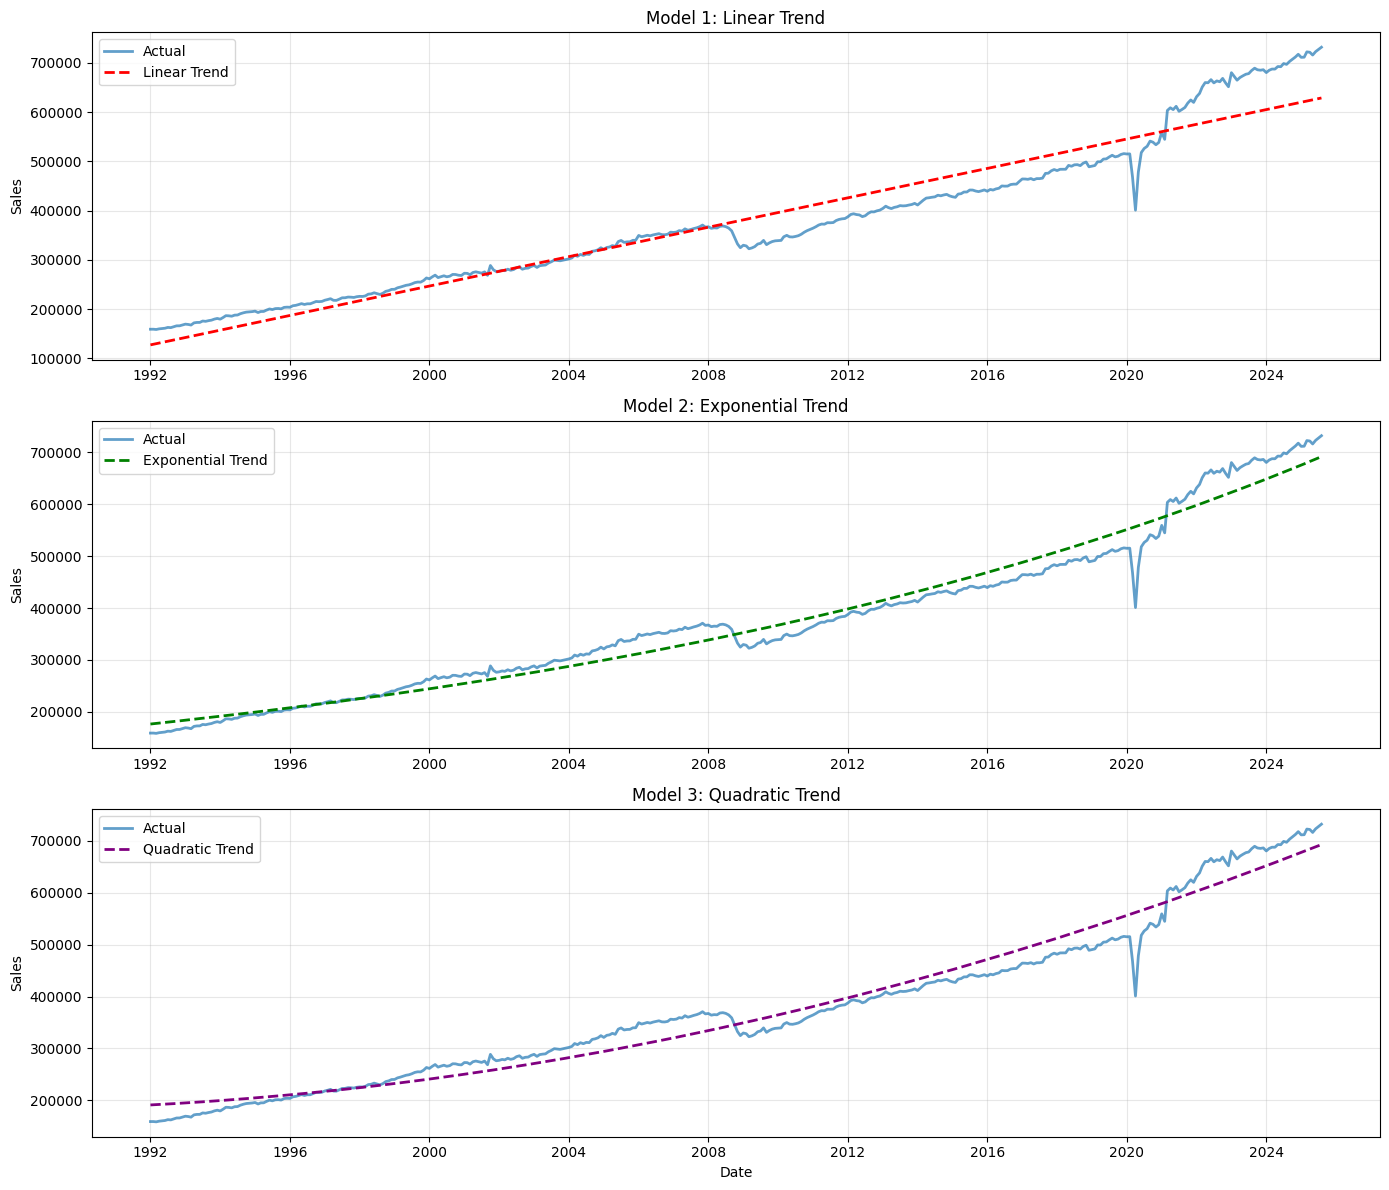

In [31]:
# =============================================================================
# 6. 모델 비교 시각화
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 모델 1: 선형 추세
axes[0].plot(retail['DATE'], retail['RSAFS'], label='Actual', linewidth=2, alpha=0.7)
axes[0].plot(retail['DATE'], retail['Linear_Fitted'], label='Linear Trend',
             linestyle='--', linewidth=2, color='red')
axes[0].set_ylabel('Sales')
axes[0].set_title('Model 1: Linear Trend')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 모델 2: 지수 추세
axes[1].plot(retail['DATE'], retail['RSAFS'], label='Actual', linewidth=2, alpha=0.7)
axes[1].plot(retail['DATE'], retail['Exp_Fitted'], label='Exponential Trend',
             linestyle='--', linewidth=2, color='green')
axes[1].set_ylabel('Sales')
axes[1].set_title('Model 2: Exponential Trend')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 모델 3: 2차 다항 추세
axes[2].plot(retail['DATE'], retail['RSAFS'], label='Actual', linewidth=2, alpha=0.7)
axes[2].plot(retail['DATE'], retail['Quad_Fitted'], label='Quadratic Trend',
             linestyle='--', linewidth=2, color='purple')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Sales')
axes[2].set_title('Model 3: Quadratic Trend')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

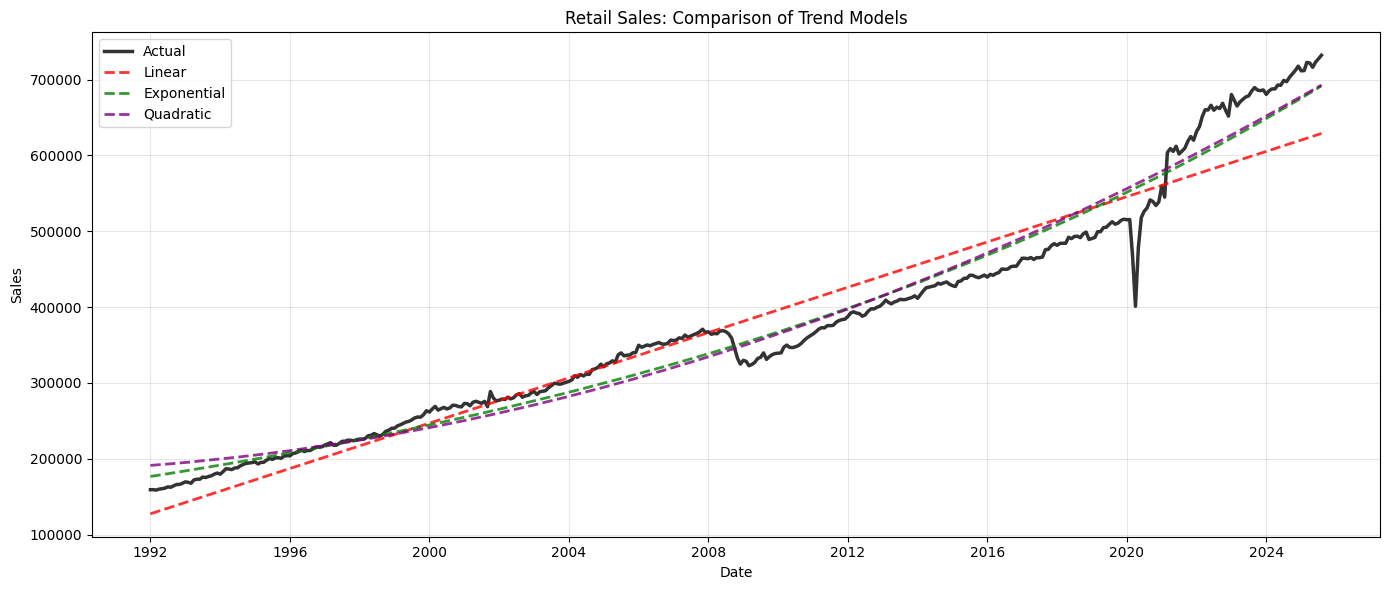

In [32]:
# =============================================================================
# 7. 세 모델 한번에 비교
# =============================================================================

plt.figure(figsize=(14, 6))
plt.plot(retail['DATE'], retail['RSAFS'], label='Actual', linewidth=2.5, alpha=0.8, color='black')
plt.plot(retail['DATE'], retail['Linear_Fitted'], label='Linear',
         linestyle='--', linewidth=2, alpha=0.8, color='red')
plt.plot(retail['DATE'], retail['Exp_Fitted'], label='Exponential',
         linestyle='--', linewidth=2, alpha=0.8, color='green')
plt.plot(retail['DATE'], retail['Quad_Fitted'], label='Quadratic',
         linestyle='--', linewidth=2, alpha=0.8, color='purple')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Retail Sales: Comparison of Trend Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

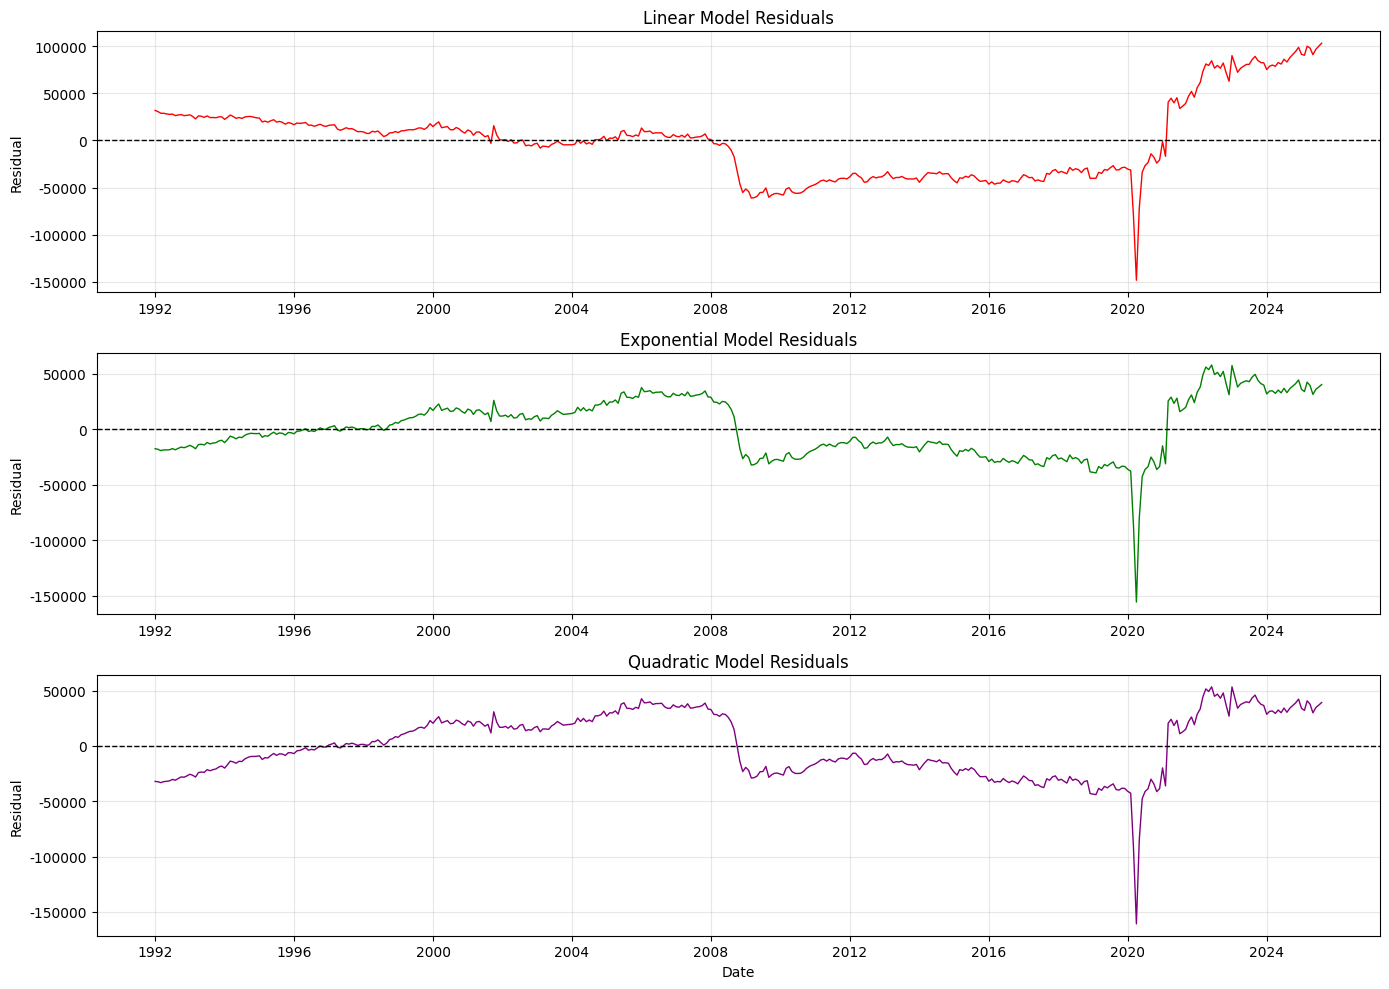

In [33]:
# =============================================================================
# 8. 잔차 비교
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 선형 모델 잔차
axes[0].plot(retail['DATE'], retail['Linear_Residual'], linewidth=1, color='red')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].set_ylabel('Residual')
axes[0].set_title('Linear Model Residuals')
axes[0].grid(True, alpha=0.3)

# 지수 모델 잔차
axes[1].plot(retail['DATE'], retail['Exp_Residual'], linewidth=1, color='green')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_ylabel('Residual')
axes[1].set_title('Exponential Model Residuals')
axes[1].grid(True, alpha=0.3)

# 2차 모델 잔차
axes[2].plot(retail['DATE'], retail['Quad_Residual'], linewidth=1, color='purple')
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Residual')
axes[2].set_title('Quadratic Model Residuals')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


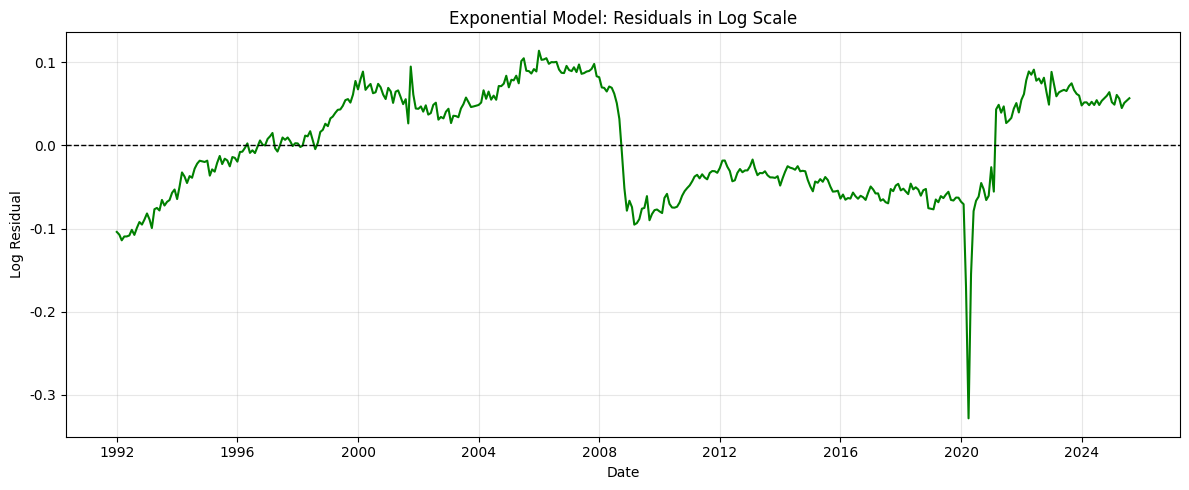

In [34]:

# =============================================================================
# 9. 로그 스케일에서의 잔차 (지수 모델)
# =============================================================================

plt.figure(figsize=(12, 5))
log_residuals = y_log - retail['Log_Fitted']
plt.plot(retail['DATE'], log_residuals, linewidth=1.5, color='green')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Log Residual')
plt.title('Exponential Model: Residuals in Log Scale')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
# =============================================================================
# 10. 모델 성능 비교 요약
# =============================================================================

comparison = pd.DataFrame({
    'Model': ['Linear', 'Exponential', 'Quadratic'],
    'R-squared': [model_linear.rsquared, None, model_quad.rsquared],
    'RMSE': [rmse_linear, rmse_exp, rmse_quad],
    'MAE': [mae_linear, mae_exp, mae_quad]
})

print(comparison.to_string(index=False))

# 최적 모델 판단
best_rmse_idx = comparison['RMSE'].idxmin()
best_model = comparison.loc[best_rmse_idx, 'Model']

print(f"\n최소 RMSE 기준 최적 모델: {best_model}")

      Model  R-squared         RMSE          MAE
     Linear   0.929176 40068.201441 31147.521692
Exponential        NaN 25966.929330 21448.823370
  Quadratic   0.965638 27909.505195 23937.975118

최소 RMSE 기준 최적 모델: Exponential


In [36]:
# =============================================================================
# 11. 추세 성장률 분석
# =============================================================================

print("\n" + "="*80)
print("추세 성장률 분석")
print("="*80)

# 선형 모델: 절대 성장량 (월별)
linear_growth = model_linear.params['Time']
print(f"\n선형 모델:")
print(f"  월별 평균 증가량: {linear_growth:.2f}")
print(f"  연간 평균 증가량: {linear_growth * 12:.2f}")

# 지수 모델: 상대 성장률 (%)
exp_growth_rate = (np.exp(model_exp.params['Time']) - 1) * 100
print(f"\n지수 모델:")
print(f"  월별 평균 성장률: {exp_growth_rate:.4f}%")
print(f"  연간 복리 성장률: {(np.exp(model_exp.params['Time'] * 12) - 1) * 100:.2f}%")

# 2차 모델: 가속도
quad_acceleration = model_quad.params['Time_Squared']
print(f"\n2차 모델:")
print(f"  Time 계수 (초기 속도): {model_quad.params['Time']:.2f}")
print(f"  Time² 계수 (가속도): {quad_acceleration:.4f}")
if quad_acceleration > 0:
    print(f"  → 성장률이 시간에 따라 가속")
else:
    print(f"  → 성장률이 시간에 따라 감속")


추세 성장률 분석

선형 모델:
  월별 평균 증가량: 1244.43
  연간 평균 증가량: 14933.14

지수 모델:
  월별 평균 성장률: 0.3393%
  연간 복리 성장률: 4.15%

2차 모델:
  Time 계수 (초기 속도): 292.04
  Time² 계수 (가속도): 2.3632
  → 성장률이 시간에 따라 가속


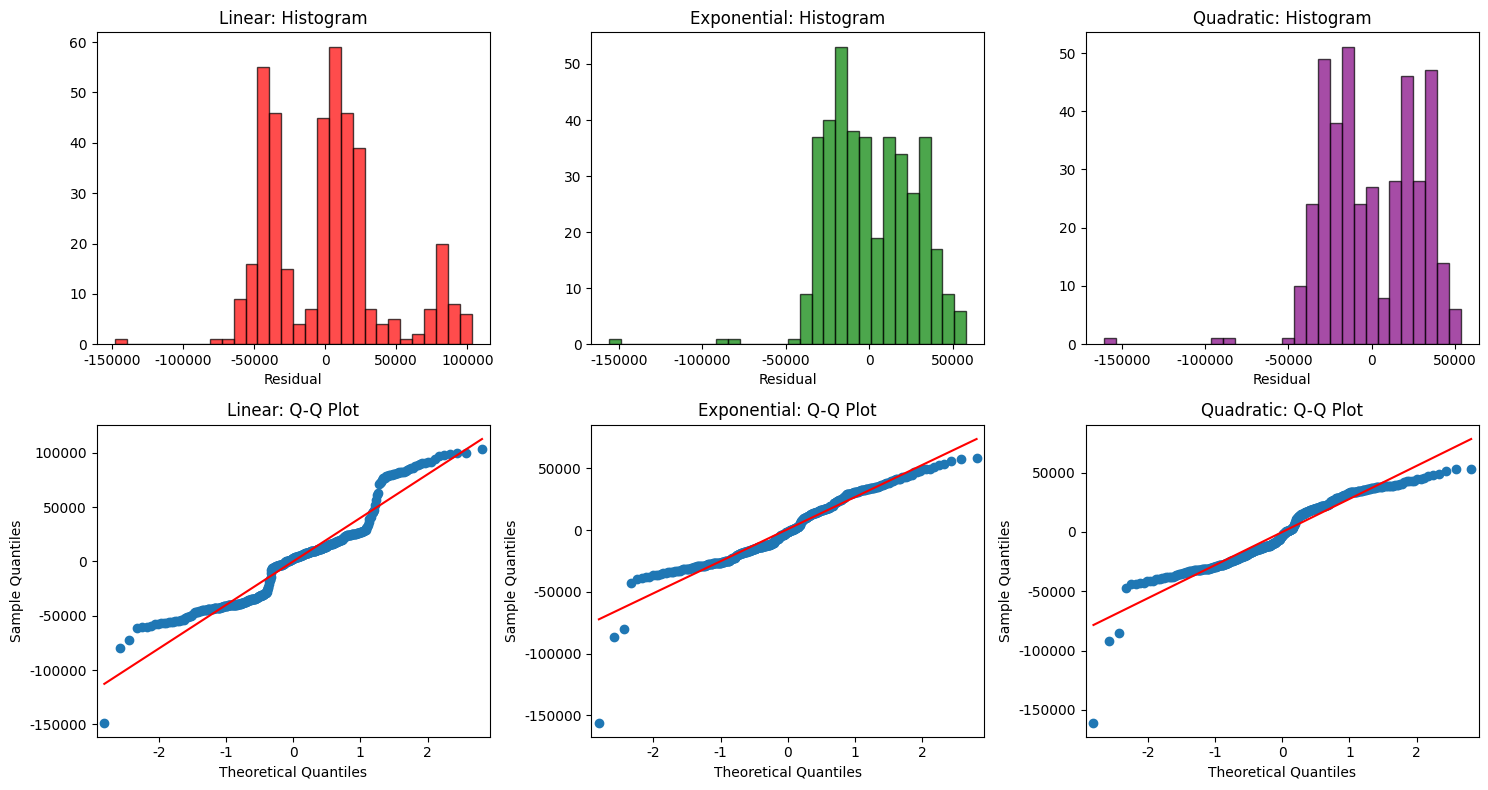

In [37]:
# =============================================================================
# 12. 잔차 진단
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 선형 모델
axes[0, 0].hist(retail['Linear_Residual'], bins=30, edgecolor='black', alpha=0.7, color='red')
axes[0, 0].set_title('Linear: Histogram')
axes[0, 0].set_xlabel('Residual')

sm.qqplot(retail['Linear_Residual'], line='s', ax=axes[1, 0])
axes[1, 0].set_title('Linear: Q-Q Plot')

# 지수 모델
axes[0, 1].hist(retail['Exp_Residual'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Exponential: Histogram')
axes[0, 1].set_xlabel('Residual')

sm.qqplot(retail['Exp_Residual'], line='s', ax=axes[1, 1])
axes[1, 1].set_title('Exponential: Q-Q Plot')

# 2차 모델
axes[0, 2].hist(retail['Quad_Residual'], bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[0, 2].set_title('Quadratic: Histogram')
axes[0, 2].set_xlabel('Residual')

sm.qqplot(retail['Quad_Residual'], line='s', ax=axes[1, 2])
axes[1, 2].set_title('Quadratic: Q-Q Plot')

plt.tight_layout()
plt.show()

# 대기 이산화탄소 농도 분기별 계절성 모델링

이 실습에서는 Mauna Loa 관측소에서 측정된 대기 중 이산화탄소(CO2) 농도 데이터를 **분기별(Quarterly)** 데이터로 변환하여 시계열 분석과 계절성 모델링을 수행합니다. 1981년 이후 데이터에 집중하여 현대 기후 변화 패턴을 분석하겠습니다.

## 데이터 설명

- **데이터 출처**: Mauna Loa Observatory, Hawaii
- **측정 단위**: ppm (parts per million)
- **원본 데이터**: 주간 측정값
- **분석 데이터**: 분기별 평균값 (1981년 이후)
- **분기 정의**:
  - Q1: 1-3월 (겨울-봄)
  - Q2: 4-6월 (봄-여름)
  - Q3: 7-9월 (여름-가을)
  - Q4: 10-12월 (가을-겨울)

In [38]:
# =============================================================================
# 라이브러리 로드
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.rcParams['axes.unicode_minus'] = False

### 1. 데이터 전처리
- 주간 데이터를 분기별 평균으로 리샘플링
- 1981년 이후 데이터만 사용 (최근 기후 패턴 집중 분석)
- 분기(Quarter)와 연도(Year) 변수 생성

In [39]:
# =============================================================================
# 1. 데이터 로드 및 전처리
# =============================================================================

# CO2 데이터 로드
co2 = sm.datasets.co2.load_pandas().data

print("Original data shape:", co2.shape)
print("\nOriginal date range:", co2.index[0], "to", co2.index[-1])

# 분기별 평균으로 리샘플링
co2 = co2.resample('QE').mean()

# 1981년 이후 데이터만 사용
co2 = co2[co2.index >= '1981-01-01']

print("\nResampled data shape:", co2.shape)
print("Date range after filtering:", co2.index[0], "to", co2.index[-1])

# 분기와 연도 정보 추가
co2_df = pd.DataFrame({
    'co2': co2.values.flatten(),
    'date': co2.index
})
co2_df['Quarter'] = co2_df['date'].dt.quarter
co2_df['Year'] = co2_df['date'].dt.year

Original data shape: (2284, 1)

Original date range: 1958-03-29 00:00:00 to 2001-12-29 00:00:00

Resampled data shape: (84, 1)
Date range after filtering: 1981-03-31 00:00:00 to 2001-12-31 00:00:00


In [40]:
# Data preview
co2_df.head(10)

,co2,date,Quarter,Year
0,340.269231,1981-03-31,1,1981
1,342.492308,1981-06-30,2,1981
2,338.500000,1981-09-30,3,1981
3,338.215385,1981-12-31,4,1981
4,341.569231,1982-03-31,1,1982
5,343.607692,1982-06-30,2,1982
6,340.015385,1982-09-30,3,1982
7,339.100000,1982-12-31,4,1982
8,342.253846,1983-03-31,1,1983
9,345.246154,1983-06-30,2,1983


In [41]:
# Data info
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   co2      84 non-null     float64       
 1   date     84 non-null     datetime64[ns]
 2   Quarter  84 non-null     int32         
 3   Year     84 non-null     int32         
dtypes: datetime64[ns](1), float64(1), int32(2)
memory usage: 2.1 KB


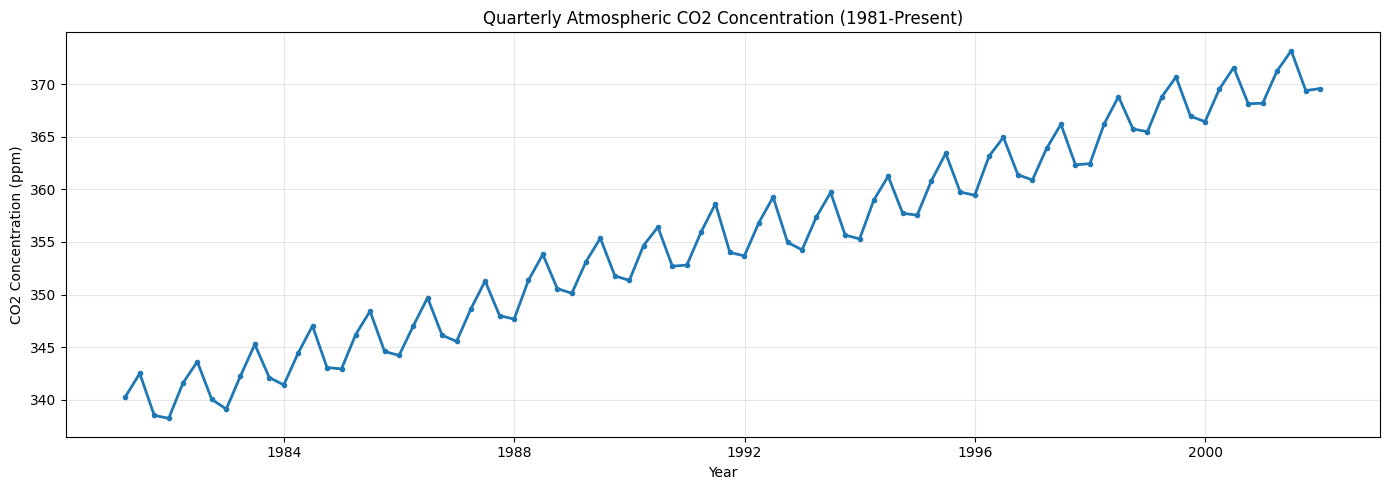

In [42]:
# 시각화
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(co2_df['date'], co2_df['co2'], linewidth=2, marker='o', markersize=3)
ax.set_xlabel('Year')
ax.set_ylabel('CO2 Concentration (ppm)')
ax.set_title('Quarterly Atmospheric CO2 Concentration (1981-Present)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2. 시계열 분해 (Seasonal Decomposition)
분기별 데이터에서 시계열을 세 가지 요소로 분리합니다:

- 추세(Trend): 장기적인 CO2 농도 증가 패턴
- 계절성(Seasonal): 4분기 주기의 반복 패턴
- 잔차(Residual): 추세와 계절성으로 설명되지 않는 변동

가법 모델(Additive Model):
```
Y(t) = T(t) + S(t) + R(t)
```

분기별 데이터의 장점:

- 노이즈 감소 (주간 변동 평활화)
- 계절성 패턴이 명확하게 드러남
- 모델 해석이 용이함

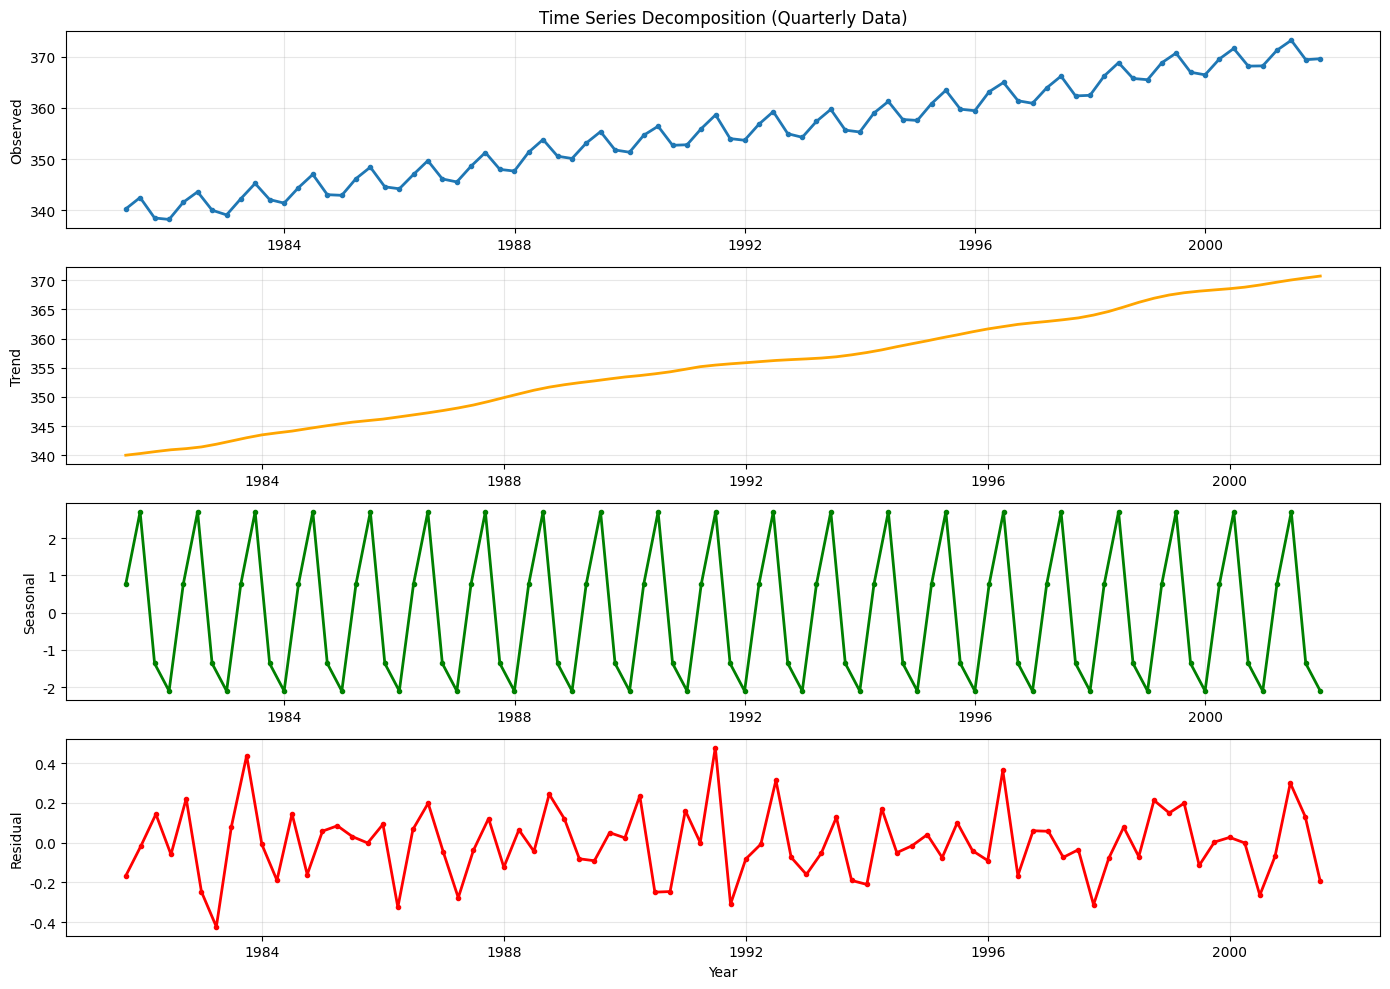

In [43]:
# =============================================================================
# 2. 시계열 분해 (Seasonal Decomposition)
# =============================================================================

# 시계열 분해 수행 (주기 = 4분기)
# 분기별 데이터이므로 1년 = 4분기
co2_series = pd.Series(co2_df['co2'].values, index=co2_df['date'])
decomposition = seasonal_decompose(co2_series, model='additive', period=4)

# 분해 결과 시각화
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# 원본 데이터
axes[0].plot(co2_series.index, co2_series.values, linewidth=2, marker='o', markersize=3)
axes[0].set_ylabel('Observed')
axes[0].set_title('Time Series Decomposition (Quarterly Data)')
axes[0].grid(True, alpha=0.3)

# 추세 (Trend)
axes[1].plot(decomposition.trend.index, decomposition.trend.values, linewidth=2, color='orange')
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

# 계절성 (Seasonal)
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, linewidth=2, color='green', marker='o', markersize=3)
axes[2].set_ylabel('Seasonal')
axes[2].grid(True, alpha=0.3)

# 잔차 (Residual)
axes[3].plot(decomposition.resid.index, decomposition.resid.values, linewidth=2, color='red', marker='o', markersize=3)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Year')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [44]:
# 계절성 성분 통계
print("="*80)
print("Seasonal Component Statistics")
print("="*80)
print(f"Min: {decomposition.seasonal.min():.4f} ppm")
print(f"Max: {decomposition.seasonal.max():.4f} ppm")
print(f"Range: {decomposition.seasonal.max() - decomposition.seasonal.min():.4f} ppm")

Seasonal Component Statistics
Min: -2.1027 ppm
Max: 2.7044 ppm
Range: 4.8071 ppm


### 3. 자기상관 분석

ACF (Autocorrelation Function): 시차별 자기상관 확인    
PACF (Partial Autocorrelation Function): 직접적인 상관관계만 추출

분기별 데이터에서는 4의 배수 시차에서 계절성으로 인한 높은 상관관계가 나타납니다.


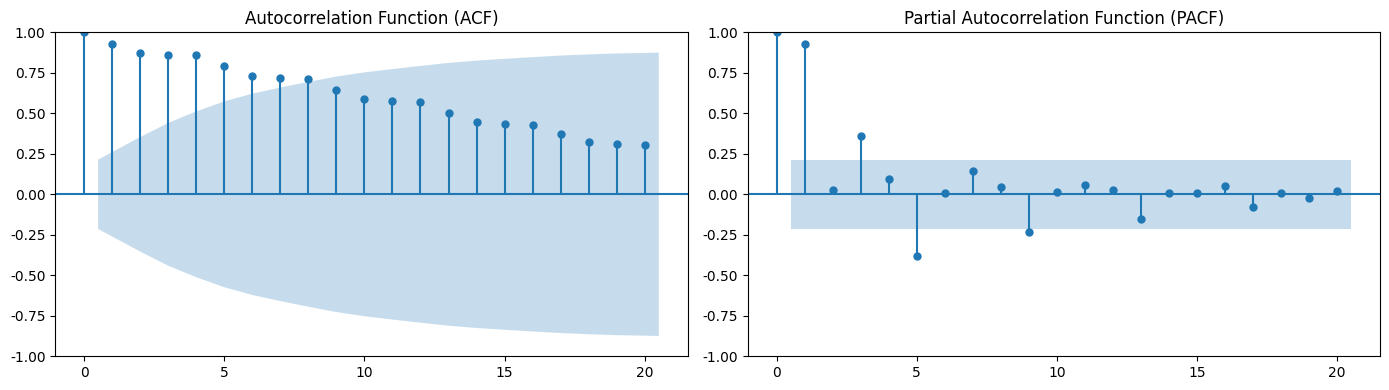

In [45]:
# =============================================================================
# 3. ACF/PACF 플롯
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF
plot_acf(co2_series.dropna(), lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF
plot_pacf(co2_series.dropna(), lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### ACF (Autocorrelation Function) 분석

#### 관찰되는 패턴

1. **매우 높은 초기 상관관계**
   - Lag 0: 1.0 (자기 자신과의 상관관계)
   - Lag 1-20: 모든 시차에서 양의 상관관계 유지
   - 천천히 감소하는 패턴 (slow decay)

2. **점진적 감소**
   - 상관계수가 0.9 → 0.3 정도로 천천히 하락
   - 20개 lag까지도 여전히 양의 상관관계

3. **신뢰구간**
   - 파란 영역: 95% 신뢰구간
   - 모든 lag가 신뢰구간을 크게 벗어남

#### 의미

**강한 추세(Trend)의 존재**

이것은 **비정상 시계열**의 전형적인 신호입니다.

- CO2 농도가 지속적으로 증가하고 있음
- 과거 값과 현재 값이 강하게 연결되어 있음
- 시간이 지나도 상관관계가 쉽게 사라지지 않음

**예시로 이해하기:**
- 오늘 CO2 농도가 높으면 → 내일도 높음 (Lag 1)
- 오늘 CO2 농도가 높으면 → 1년 후에도 높을 가능성 큼 (Lag 4)
- 오늘 CO2 농도가 높으면 → 5년 후에도 높을 가능성 있음 (Lag 20)

이는 **추세가 지배적**이라는 의미입니다.

---

### PACF (Partial Autocorrelation Function) 분석

#### 관찰되는 패턴

**Lag 1에서 매우 높은 값**
   - 약 0.95 수준
   - 신뢰구간을 크게 초과


#### 의미

**AR(1) 또는 AR(2) 구조 시사**

PACF가 초기 몇 개의 lag 이후 급격히 감소(cutoff)하는 것은:

1. **Lag 1의 영향이 지배적**
   - 바로 직전 분기의 CO2 농도가 현재에 가장 큰 영향
   - "어제의 나 → 오늘의 나"와 같은 직접적 영향

3. **Lag 3 이후는 거의 무의미**
   - Lag 1, 2를 통해 이미 설명됨
   - 추가적인 독립적 정보가 거의 없음

사실상 이 결과로만 본다면 회귀 분석보다는 AR 계열 모델 활용이 더 적합!

### 4. 회귀 모델 구축

두 가지 모델을 비교합니다:

#### **모델 1: 선형 추세 + 계절성**
```
CO2(t) = β₀ + β₁·time + β₂·Q2 + β₃·Q3 + β₄·Q4 + ε
```

#### **모델 2: 2차 추세 + 계절성**
```
CO2(t) = β₀ + β₁·time + β₂·time² + β₃·Q2 + β₄·Q3 + β₅·Q4 + ε
```

**변수 설명:**
- **time**: 선형 추세 (시간의 1차 효과)
- **time²**: 2차 추세 (가속화되는 증가율 포착)
- **Q2, Q3, Q4**: 분기별 더미 변수 (Q1 기준)
- **상수항 β₀**: 기준 수준(Q1, time=0)

In [46]:
# =============================================================================
# 4. 계절성 더미 변수를 활용한 회귀 모델
# =============================================================================

# 시간 변수 생성 (선형 추세)
co2_df['time'] = np.arange(len(co2_df))

# 2차 추세 변수 생성 (비선형 추세 포착)
co2_df['time_squared'] = co2_df['time'] ** 2

# 분기를 문자열로 변환 (더미 변수 생성을 위해)
co2_df['Quarter_str'] = 'Q' + co2_df['Quarter'].astype(str)

# 계절성 더미 변수 생성 (Q1을 기준으로)
co2_df = pd.get_dummies(co2_df, columns=['Quarter_str'], prefix='Quarter', drop_first=True)

In [47]:
# DataFrame with dummy variables
co2_df.head()

,co2,date,Quarter,Year,time,time_squared,Quarter_Q2,Quarter_Q3,Quarter_Q4
0,340.269231,1981-03-31,1,1981,0,0,False,False,False
1,342.492308,1981-06-30,2,1981,1,1,True,False,False
2,338.500000,1981-09-30,3,1981,2,4,False,True,False
3,338.215385,1981-12-31,4,1981,3,9,False,False,True
4,341.569231,1982-03-31,1,1982,4,16,False,False,False


In [48]:
print("\nColumns:", co2_df.columns.tolist())


Columns: ['co2', 'date', 'Quarter', 'Year', 'time', 'time_squared', 'Quarter_Q2', 'Quarter_Q3', 'Quarter_Q4']


In [49]:
# =============================================================================
# 모델 1: 선형 추세 + 계절성
# =============================================================================

# 독립 변수와 종속 변수 설정
X_cols_linear = ['time'] + [col for col in co2_df.columns if col.startswith('Quarter_')]
X_linear = co2_df[X_cols_linear].astype(float)
y = co2_df['co2'].astype(float)

# 상수항 추가
X_linear = sm.add_constant(X_linear)

# 선형 회귀 모델 피팅
model_linear = sm.OLS(y, X_linear)
results_linear = model_linear.fit()

# 모델 요약 출력
print("\n" + "="*80)
print("Model 1: Linear Trend + Seasonal Dummy Variables")
print("="*80)
print(results_linear.summary())

# 예측값 생성
co2_df['predicted_linear'] = results_linear.fittedvalues


Model 1: Linear Trend + Seasonal Dummy Variables
                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     4710.
Date:                Fri, 10 Oct 2025   Prob (F-statistic):           4.19e-93
Time:                        13:42:35   Log-Likelihood:                -78.267
No. Observations:                  84   AIC:                             166.5
Df Residuals:                      79   BIC:                             178.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [50]:
# =============================================================================
# 모델 2: 2차 추세 + 계절성
# =============================================================================

# 독립 변수 설정 (2차 항 포함)
X_cols_quad = ['time', 'time_squared'] + [col for col in co2_df.columns if col.startswith('Quarter_')]
X_quad = co2_df[X_cols_quad].astype(float)

# 상수항 추가
X_quad = sm.add_constant(X_quad)

# 2차 회귀 모델 피팅
model_quad = sm.OLS(y, X_quad)
results_quad = model_quad.fit()

# 모델 요약 출력
print("\n" + "="*80)
print("Model 2: Quadratic Trend + Seasonal Dummy Variables")
print("="*80)
print(results_quad.summary())

# 예측값 생성
co2_df['predicted_quad'] = results_quad.fittedvalues



Model 2: Quadratic Trend + Seasonal Dummy Variables
                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     3827.
Date:                Fri, 10 Oct 2025   Prob (F-statistic):           1.03e-91
Time:                        13:42:35   Log-Likelihood:                -77.085
No. Observations:                  84   AIC:                             166.2
Df Residuals:                      78   BIC:                             180.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

### 5. 모델 평가 및 비교

다음 지표로 두 모델을 비교합니다:

- **R² (R-squared)**: 모델이 설명하는 분산 비율
- **Adjusted R²**: 변수 개수를 고려한 조정된 R²
- **RMSE**: 예측 오차의 평균 크기
- **MAE**: 절대 오차의 평균

In [51]:
# =============================================================================
# 8. 모델 평가 및 비교
# =============================================================================

# 평가 지표 계산 - 선형 모델
mse_linear = mean_squared_error(y, co2_df['predicted_linear'])
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y, co2_df['predicted_linear'])

# 평가 지표 계산 - 2차 모델
mse_quad = mean_squared_error(y, co2_df['predicted_quad'])
rmse_quad = np.sqrt(mse_quad)
mae_quad = mean_absolute_error(y, co2_df['predicted_quad'])

print("\n" + "="*80)
print("Model Evaluation Metrics Comparison")
print("="*80)
print(f"\nLinear Model:")
print(f"  R-squared: {results_linear.rsquared:.6f}")
print(f"  Adjusted R-squared: {results_linear.rsquared_adj:.6f}")
print(f"  RMSE: {rmse_linear:.4f} ppm")
print(f"  MAE: {mae_linear:.4f} ppm")

print(f"\nQuadratic Model:")
print(f"  R-squared: {results_quad.rsquared:.6f}")
print(f"  Adjusted R-squared: {results_quad.rsquared_adj:.6f}")
print(f"  RMSE: {rmse_quad:.4f} ppm")
print(f"  MAE: {mae_quad:.4f} ppm")

print(f"\nImprovement (Quadratic vs Linear):")
print(f"  R-squared improvement: {(results_quad.rsquared - results_linear.rsquared)*100:.4f}%")
print(f"  RMSE reduction: {(rmse_linear - rmse_quad):.4f} ppm ({((rmse_linear - rmse_quad)/rmse_linear)*100:.2f}%)")


Model Evaluation Metrics Comparison

Linear Model:
  R-squared: 0.995825
  Adjusted R-squared: 0.995613
  RMSE: 0.6143 ppm
  MAE: 0.4896 ppm

Quadratic Model:
  R-squared: 0.995941
  Adjusted R-squared: 0.995680
  RMSE: 0.6058 ppm
  MAE: 0.4845 ppm

Improvement (Quadratic vs Linear):
  R-squared improvement: 0.0116%
  RMSE reduction: 0.0086 ppm (1.40%)


**결과 해석:**
2차 모델이 선형 모델보다 높은 R²와 낮은 RMSE를 보입니다. 이는 CO2 증가율이 가속화되고 있음을 의미합니다. 하지만 BIC 기준이라면, 그리고 quadratic term의 통계적 유의성을 본다면 해석이 달라질 수 있습니다

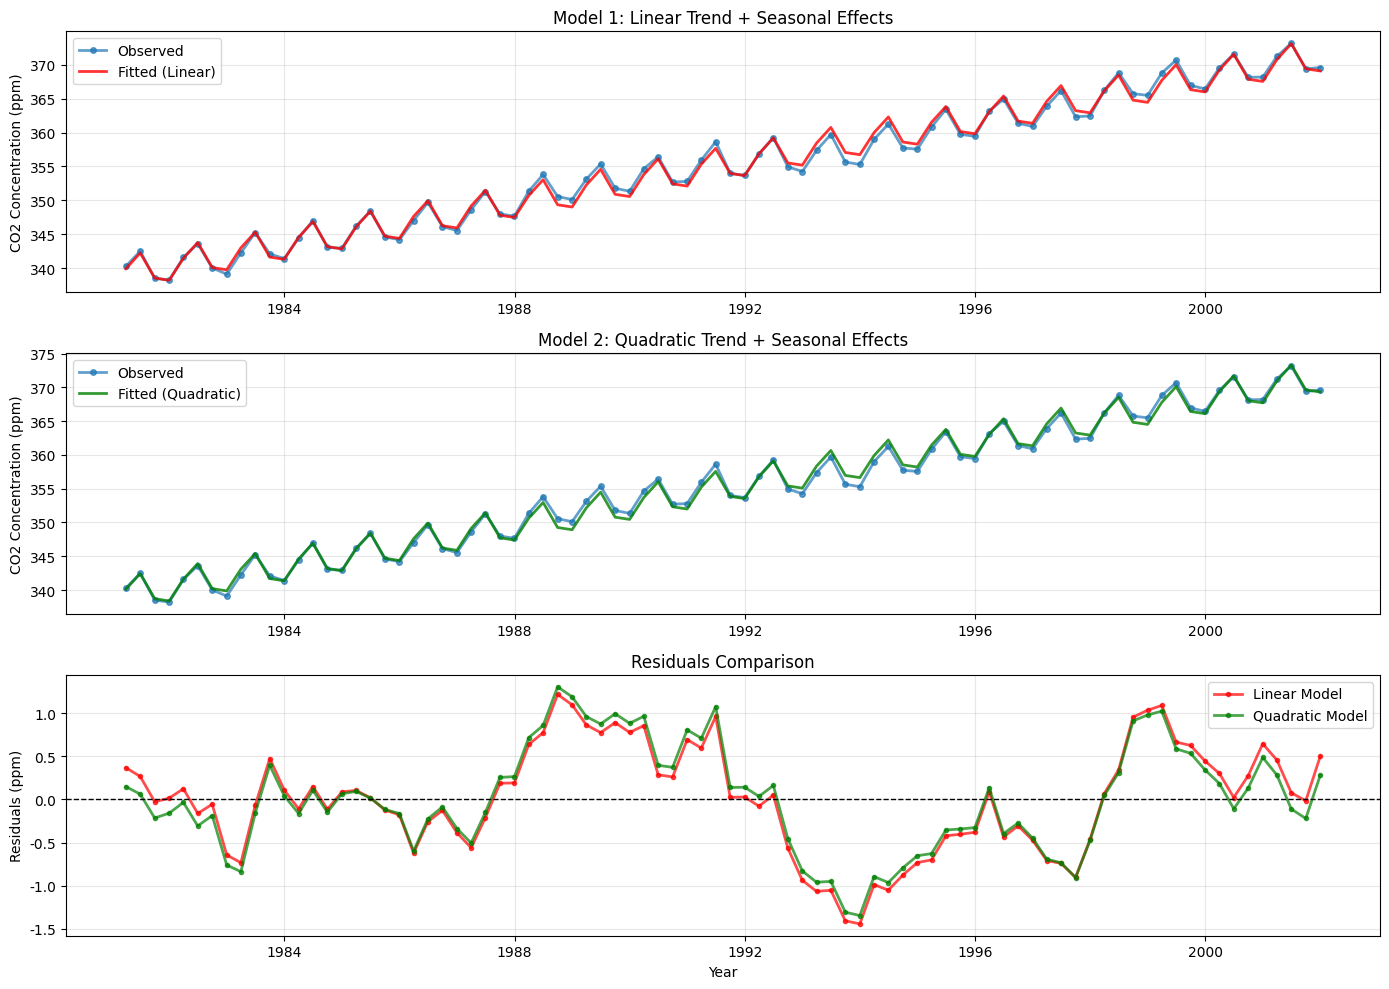

In [52]:
# =============================================================================
# 예측 결과 시각화
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 모델 1: 선형 추세
axes[0].plot(co2_df['date'], co2_df['co2'], label='Observed', linewidth=2, marker='o', markersize=4, alpha=0.7)
axes[0].plot(co2_df['date'], co2_df['predicted_linear'], label='Fitted (Linear)', linewidth=2, color='red', alpha=0.8)
axes[0].set_ylabel('CO2 Concentration (ppm)')
axes[0].set_title('Model 1: Linear Trend + Seasonal Effects')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 모델 2: 2차 추세
axes[1].plot(co2_df['date'], co2_df['co2'], label='Observed', linewidth=2, marker='o', markersize=4, alpha=0.7)
axes[1].plot(co2_df['date'], co2_df['predicted_quad'], label='Fitted (Quadratic)', linewidth=2, color='green', alpha=0.8)
axes[1].set_ylabel('CO2 Concentration (ppm)')
axes[1].set_title('Model 2: Quadratic Trend + Seasonal Effects')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 잔차 비교
residuals_linear = co2_df['co2'] - co2_df['predicted_linear']
residuals_quad = co2_df['co2'] - co2_df['predicted_quad']

axes[2].plot(co2_df['date'], residuals_linear, linewidth=2, color='red', alpha=0.7, label='Linear Model', marker='o', markersize=3)
axes[2].plot(co2_df['date'], residuals_quad, linewidth=2, color='green', alpha=0.7, label='Quadratic Model', marker='o', markersize=3)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Residuals (ppm)')
axes[2].set_title('Residuals Comparison')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6. 잔차 분석
모델의 적합성을 검증합니다:

- 잔차 시계열: 체계적 패턴이 남아있는지 확인 (위의 그림에서 확인)
- 히스토그램: 정규분포 가정 확인
- Q-Q Plot: 정규성 검정
- 잔차 vs 예측값: 등분산성 확인

좋은 모델의 조건:

- 잔차 평균 ≈ 0
- 잔차에 체계적 패턴 없음
- 정규분포에 가까움
- 등분산성 (일정한 분산)

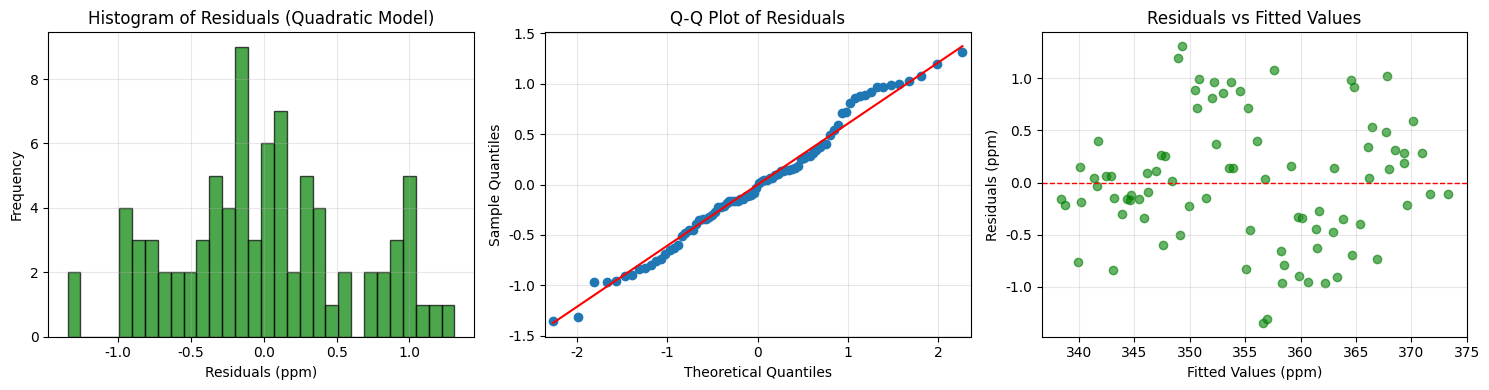

In [53]:
# =============================================================================
# 6. 잔차 분석 (2차 모델)
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 잔차 히스토그램
axes[0].hist(residuals_quad, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0].set_xlabel('Residuals (ppm)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Residuals (Quadratic Model)')
axes[0].grid(True, alpha=0.3)

# 잔차 Q-Q plot
sm.qqplot(residuals_quad, line='s', ax=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')
axes[1].grid(True, alpha=0.3)

# 잔차 vs 예측값
axes[2].scatter(co2_df['predicted_quad'], residuals_quad, alpha=0.6, color='green')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[2].set_xlabel('Fitted Values (ppm)')
axes[2].set_ylabel('Residuals (ppm)')
axes[2].set_title('Residuals vs Fitted Values')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

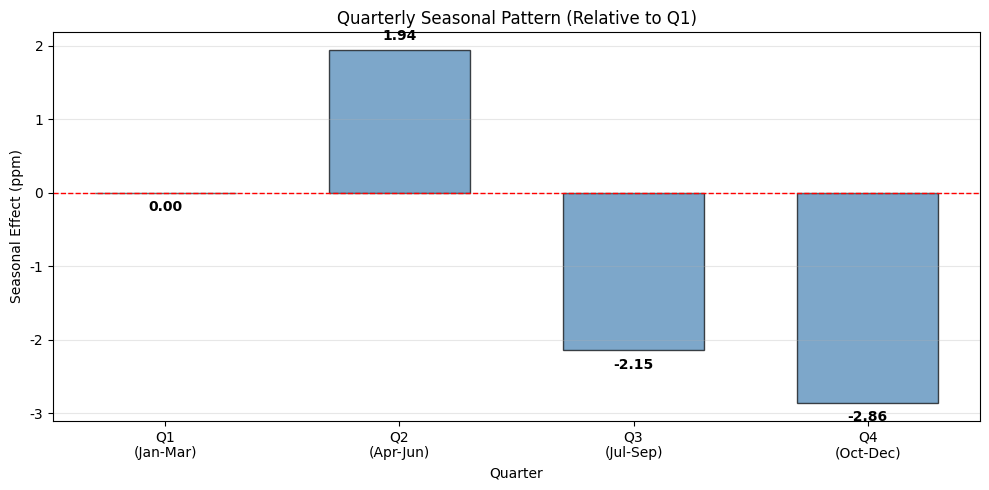

In [54]:
# =============================================================================
# 계절성 패턴 시각화
# =============================================================================

# 분기별 계수 추출 (2차 모델 기준)
seasonal_coeffs = {}
seasonal_coeffs[1] = 0  # Q1은 기준이므로 0

for q in range(2, 5):  # Q2, Q3, Q4
    col_name = f'Quarter_Q{q}'
    if col_name in results_quad.params.index:
        seasonal_coeffs[q] = results_quad.params[col_name]

# 계절성 패턴 플롯
fig, ax = plt.subplots(figsize=(10, 5))
quarters = list(seasonal_coeffs.keys())
coefficients = list(seasonal_coeffs.values())

ax.bar(quarters, coefficients, color='steelblue', alpha=0.7, edgecolor='black', width=0.6)
ax.set_xlabel('Quarter')
ax.set_ylabel('Seasonal Effect (ppm)')
ax.set_title('Quarterly Seasonal Pattern (Relative to Q1)')
ax.set_xticks(quarters)
ax.set_xticklabels(['Q1\n(Jan-Mar)', 'Q2\n(Apr-Jun)', 'Q3\n(Jul-Sep)', 'Q4\n(Oct-Dec)'])
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for i, (q, coef) in enumerate(zip(quarters, coefficients)):
    ax.text(q, coef + 0.1 if coef > 0 else coef - 0.1, f'{coef:.2f}',
            ha='center', va='bottom' if coef > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

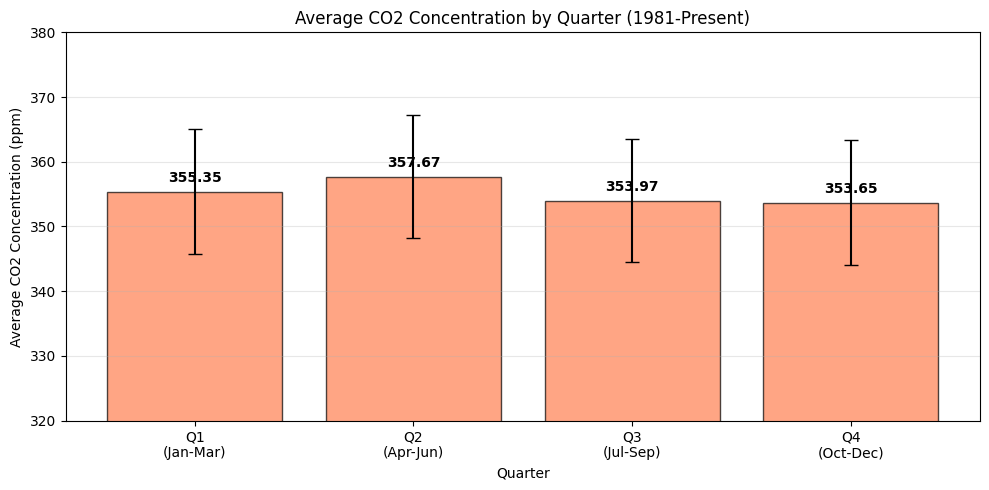

In [55]:
# =============================================================================
# 분기별 평균 CO2 농도 시각화
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 5))

quarter_avg = co2_df.groupby('Quarter')['co2'].mean()
quarter_std = co2_df.groupby('Quarter')['co2'].std()

ax.bar(quarter_avg.index, quarter_avg.values, yerr=quarter_std.values,
       capsize=5, alpha=0.7, color='coral', edgecolor='black')
ax.set_xlabel('Quarter')
ax.set_ylabel('Average CO2 Concentration (ppm)')
ax.set_ylim(bottom=320, top=380)
ax.set_title('Average CO2 Concentration by Quarter (1981-Present)')
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['Q1\n(Jan-Mar)', 'Q2\n(Apr-Jun)', 'Q3\n(Jul-Sep)', 'Q4\n(Oct-Dec)'])
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for q, avg in quarter_avg.items():
    ax.text(q, avg + 1, f'{avg:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [56]:
print("\n" + "="*80)
print("Quarterly Average CO2 Concentration")
print("="*80)
for q, avg in quarter_avg.items():
    print(f"Q{q}: {avg:.2f} ± {quarter_std[q]:.2f} ppm")


Quarterly Average CO2 Concentration
Q1: 355.35 ± 9.66 ppm
Q2: 357.67 ± 9.53 ppm
Q3: 353.97 ± 9.54 ppm
Q4: 353.65 ± 9.69 ppm
